# Connect Google Drive

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prerequisites

In [33]:
from pathlib import Path

data_dir = Path("/content/drive/MyDrive/OTH/space-eye/dataset/tc_images")

In [34]:
!pip install -q rasterio

#Create Datasets

## 1st Dataset: Crop TIF and flatten datastructure

In [ ]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import cv2

dest_dir = Path("/content/drive/MyDrive/OTH/space-eye/dataset/flattened_cropped")

def crop_middle(data: np.array, size=400, randomnes=25):
    rows = data.shape[0]
    cols = data.shape[1]
    mid_row = int(rows/2)
    mid_col = int(cols/2)
    start_row = mid_row - int(size/2)
    start_col = mid_col - int(size/2)
    col_dist, row_dist = np.random.randint(low=-randomnes, high=randomnes, size=2)
    start_row += row_dist
    start_col += col_dist
    data = data[start_row : start_row+size, start_col: start_col+size,:]
    return data

#load files
for classifier in ["ships", "non_ships"]:
  classifier_dir = os.path.join(data_dir, classifier)
  for item in sorted(os.listdir(classifier_dir), key=int):
    # assemble paths
    item_dir = os.path.join(classifier_dir, item)
    src_filename = list(Path(item_dir).glob("*.tif"))[0].name
    src_file = os.path.join(item_dir, src_filename)
    dst_filename = classifier.replace("_", "") + "_image_" + item + ".tif"
    dst_file = os.path.join(dest_dir, classifier.replace("_", ""), dst_filename )
    print(src_file)
    print("--> " + dst_file)

    # load data
    with rasterio.open(src_file) as src_ds:
      data = src_ds.read()
      profile = src_ds.profile
    # crop
    data = crop_middle(data)
    
    #save data
    Path(dst_file).parent.mkdir(parents=True, exist_ok=True)
    profile.update(count=data.shape[0], width=data.shape[1], height=data.shape[2])
    with rasterio.open(dst_file, 'w', **profile) as dst_ds:
      data = dst_ds.write(data)

KeyboardInterrupt: ignored

### Show a cropped image

Verify we are converting correctly

(4, 400, 400)
(400, 400, 4)


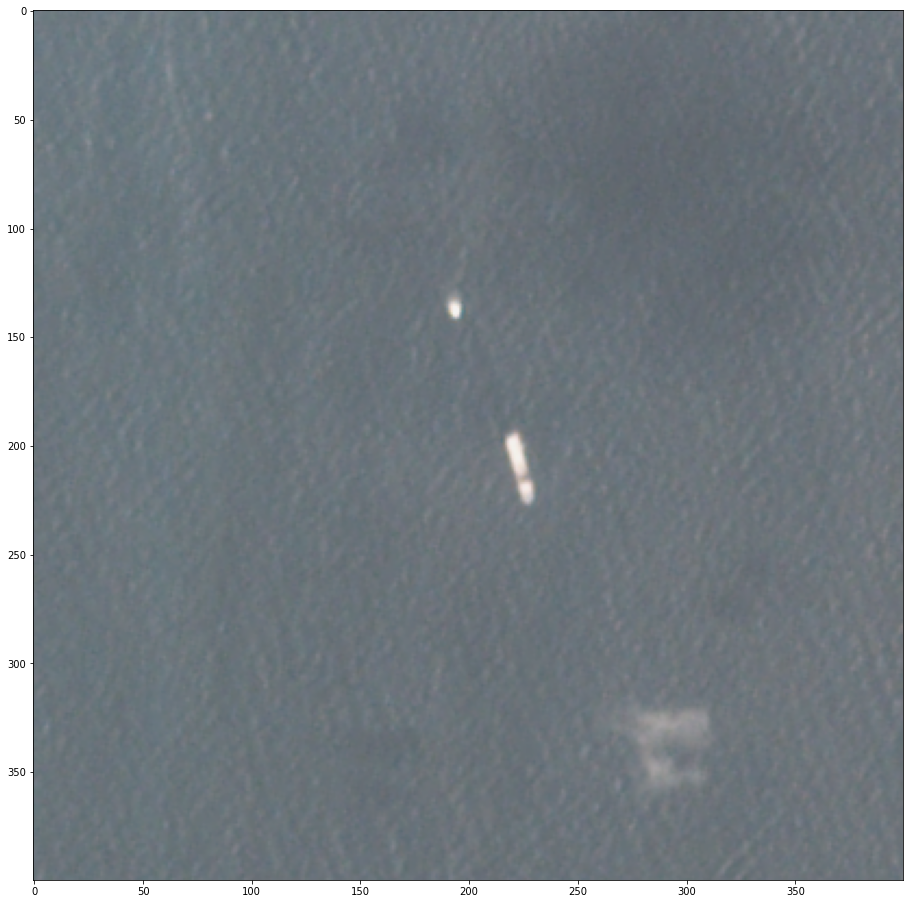

In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Test

#img_fn = Path("/content/drive/MyDrive/OTH/space-eye/dataset/flattened/nonships/nonships_image_242.tif")
img_fn = Path("/content/drive/MyDrive/OTH/space-eye/dataset/flattened_cropped/ships/ships_image_301.tif")
src_ds = rasterio.open(img_fn)
data = src_ds.read()

print(data.shape)

data = data.swapaxes(0,2).swapaxes(0,1)

print(data.shape)

plt.figure(figsize=(16,16))
plt.imshow(data[:,:,[2,1,0]])

## 2nd Dataset: Crop at 600x600px and convert to jpg

TIF is just hard to use with keras as data augmentation does not support 16-bit images and there is no easy way to avoid having load the entire dataset in memory, so I decided to convert the dataset to JPG

I am center cropping now to 600px wide as I noticed some ships get cut off with 400px, for example ship 22.

During processing I noticed ~~some (tbd)~~ one (ships_302) images were converted incorrectly previosly and have a higher range of pixel values than the other pictures.

In [ ]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
from PIL import Image

dest_dir = Path("/content/drive/MyDrive/OTH/space-eye/dataset/jpg600")
new_height = 600
new_width = 600

skipped = list()

#load files
for classifier in ["ships", "non_ships"]:
  classifier_dir = os.path.join(data_dir, classifier)
  for item in sorted(os.listdir(classifier_dir), key=int):
    # assemble paths
    item_dir = os.path.join(classifier_dir, item)
    src_filename = list(Path(item_dir).glob("*.tif"))[0].name
    src_file = os.path.join(item_dir, src_filename)
    dst_filename = classifier.replace("_", "") + "_image_" + item + ".jpg"
    dst_file = os.path.join(dest_dir, classifier.replace("_", ""), dst_filename )
    print(src_file)
    print("--> " + dst_file)

    # load data
    with rasterio.open(src_file) as src_ds:
      data = src_ds.read()
    # swap axes
    data = data.swapaxes(0,2).swapaxes(0,1)
    # remove NIR
    data = data[:,:,0:3]
    # reverse color channels to get BGR -> RGB
    data = data[:,:,[2,1,0]]

    print(data.shape)
    print(np.amax(data))
    print(np.amin(data))
    
    #skip corrupted/badly converted files
    # maybe these are salvageable, but no time to investigate
    if(np.amax(data) > 255): 
      print("skipped!")
      skipped.append(src_file)
      continue

    image = Image.fromarray(data)

    # convert range
    image.point(lambda i:i*(1./256))

    
    # crop center
    width, height = image.size   # Get dimensions
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    image = image.crop((left, top, right, bottom))
    

    #save data
    Path(dst_file).parent.mkdir(parents=True, exist_ok=True)
    image.save(dst_file)

print("Images that were skipped:")
print(skipped)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
--> /content/drive/MyDrive/OTH/space-eye/dataset/jpg600/ships/ships_image_751.jpg
(1488, 1344, 3)
251
0
/content/drive/MyDrive/OTH/space-eye/dataset/tc_images/ships/752/20171208_161242_0f2b_3B_AnalyticMS_clip_tc.tif
--> /content/drive/MyDrive/OTH/space-eye/dataset/jpg600/ships/ships_image_752.jpg
(1488, 1346, 3)
245
0
/content/drive/MyDrive/OTH/space-eye/dataset/tc_images/ships/753/20171208_161243_0f2b_3B_AnalyticMS_clip_tc.tif
--> /content/drive/MyDrive/OTH/space-eye/dataset/jpg600/ships/ships_image_753.jpg
(1487, 1345, 3)
251
0
/content/drive/MyDrive/OTH/space-eye/dataset/tc_images/ships/754/20171208_161239_0f2b_3B_AnalyticMS_clip_tc.tif
--> /content/drive/MyDrive/OTH/space-eye/dataset/jpg600/ships/ships_image_754.jpg
(1487, 1348, 3)
250
0
/content/drive/MyDrive/OTH/space-eye/dataset/tc_images/ships/755/20171208_161243_0f2b_3B_AnalyticMS_clip_tc.tif
--> /content/drive/MyDrive/OTH/space-eye/dataset/jpg600/ships/ships_i

### Display a converted image

Verify we are converting correctly

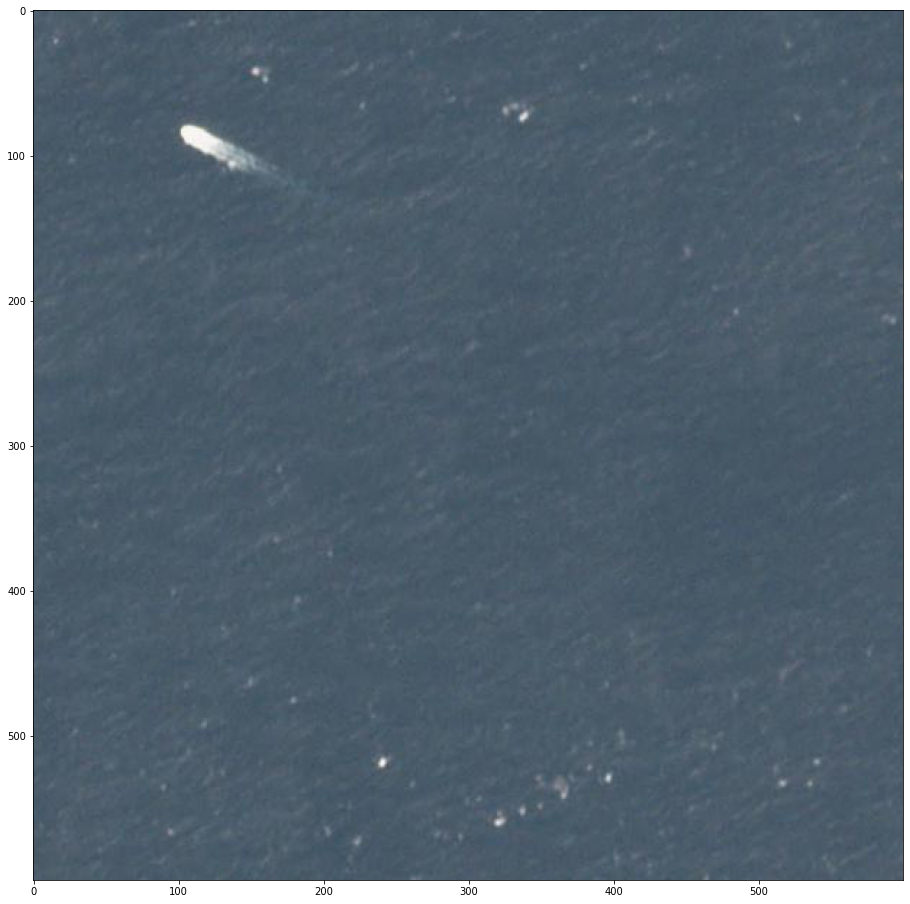

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Test

img_fn = Path("/content/drive/MyDrive/OTH/space-eye/dataset/jpg600/ships/ships_image_22.jpg")

image = Image.open(img_fn, 'r')

data = np.asarray(image)

plt.figure(figsize=(16,16))
plt.imshow(data)

## 3rd Dataset: Convert to jpg and extract NIR channel (for presentation purposes)

In [35]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
from PIL import Image

dest_dir = Path("/content/drive/MyDrive/OTH/space-eye/dataset/jpg_nir")
#new_height = 600
#new_width = 600

skipped = list()

#load files
for classifier in ["ships", "non_ships"]:
  classifier_dir = os.path.join(data_dir, classifier)
  for item in sorted(os.listdir(classifier_dir), key=int):
    # assemble paths
    item_dir = os.path.join(classifier_dir, item)
    src_filename = list(Path(item_dir).glob("*.tif"))[0].name
    src_file = os.path.join(item_dir, src_filename)
    dst_filename = classifier.replace("_", "") + "_image_" + item + ".jpg"
    nir_filename = classifier.replace("_", "") + "_nir_" + item + ".jpg"
    dst_file = os.path.join(dest_dir, classifier.replace("_", ""), dst_filename )
    nir_file = os.path.join(dest_dir, classifier.replace("_", ""), nir_filename )
    print(src_file)
    print("--> " + dst_file)
    print("--> " + nir_file)

    # load data
    with rasterio.open(src_file) as src_ds:
      data = src_ds.read()
    # swap axes
    data = data.swapaxes(0,2).swapaxes(0,1)
    # extract NIR
    nir = data[:,:,3]
    data = data[:,:,0:3]
    # reverse color channels to get BGR -> RGB
    data = data[:,:,[2,1,0]]

    print(data.shape)
    print(np.amax(data))
    print(np.amin(data))
    
    #skip corrupted/badly converted files
    # maybe these are salvageable, but no time to investigate
    if(np.amax(data) > 255): 
      print("skipped!")
      skipped.append(src_file)
      continue

    rgbimage = Image.fromarray(data)
    nirimage = Image.fromarray(nir)

    # convert range
    #rgbimage.point(lambda i:i*(1./256))
    #nirimage.point(lambda i:i*(1./256))

    # # crop center
    # width, height = image.size   # Get dimensions
    # left = (width - new_width)/2
    # top = (height - new_height)/2
    # right = (width + new_width)/2
    # bottom = (height + new_height)/2
    # image = image.crop((left, top, right, bottom))
    

    #save data
    dst_file = Path(dst_file)
    Path(dst_file).parent.mkdir(parents=True, exist_ok=True)
    rgbimage.save(dst_file)
    nirimage.save(nir_file)

print("Images that were skipped:")
print(skipped)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
/content/drive/MyDrive/OTH/space-eye/dataset/tc_images/non_ships/47/20170226_195101_0d05_3B_AnalyticMS_clip_tc.tif
--> /content/drive/MyDrive/OTH/space-eye/dataset/jpg_nir/nonships/nonships_image_47.jpg
--> /content/drive/MyDrive/OTH/space-eye/dataset/jpg_nir/nonships/nonships_nir_47.jpg
(1487, 1348, 3)
243
0
/content/drive/MyDrive/OTH/space-eye/dataset/tc_images/non_ships/48/20170217_143816_0c46_3B_AnalyticMS_clip_tc.tif
--> /content/drive/MyDrive/OTH/space-eye/dataset/jpg_nir/nonships/nonships_image_48.jpg
--> /content/drive/MyDrive/OTH/space-eye/dataset/jpg_nir/nonships/nonships_nir_48.jpg
(1488, 1342, 3)
203
0
/content/drive/MyDrive/OTH/space-eye/dataset/tc_images/non_ships/49/20170217_143815_0c46_3B_AnalyticMS_clip_tc.tif
--> /content/drive/MyDrive/OTH/space-eye/dataset/jpg_nir/nonships/nonships_image_49.jpg
--> /content/drive/MyDrive/OTH/space-eye/dataset/jpg_nir/nonships/nonships_nir_49.jpg
(1488, 1342, 3)
244
0


### Display a converted image

Verify we are converting correctly

In [42]:
import matplotlib.pyplot as plt
from PIL import Image

# Test

img_fn = Path("/content/drive/MyDrive/OTH/space-eye/dataset/jpg_nir/ships/ships_image_854.jpg")
nir_fn = Path("/content/drive/MyDrive/OTH/space-eye/dataset/jpg_nir/ships/ships_nir_854.jpg")

image = Image.open(img_fn, 'r')
nirimage = Image.open(nir_fn, 'r')


data = np.asarray(image)
nirdata = np.asarray(nirimage)

fig = plt.figure(figsize=(40,40))
ax = fig.add_subplot(1,2,1)
ax.axis('off')
ax.imshow(data)
ax = fig.add_subplot(1,2,2)
ax.axis('off')
ax.imshow(nirdata, cmap='gray', vmin=0, vmax=255)
plt.subplots_adjust(wspace=0, hspace=0)


# plt.figure(figsize=(16,16))
# plt.imshow(data)
# plt.show()

# plt.figure(figsize=(16,16))
# plt.imshow(nirdata)
# plt.show()

Output hidden; open in https://colab.research.google.com to view.